In [0]:
import numpy as np 
import pandas as pd 
import sklearn as sk 
from sklearn.preprocessing import scale 
from zipfile import ZipFile 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import math
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score


In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
def download_source():
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  # This permissions change avoids a warning on Kaggle tool startup.
  !chmod 600 ~/.kaggle/kaggle.json
  # Download the data and extract the zip 
  !kaggle competitions download -c ieee-fraud-detection
  zlist = !ls -1 *.zip
  for file in zlist:
    print(file)
    with ZipFile(file, 'r') as zip: 
       zip.printdir()
       zip.extractall()


In [0]:
def get_data(): 

  Xt_test = pd.read_csv('test_transaction.csv')
  Xt_train = pd.read_csv('train_transaction.csv')
  Xi_test = pd.read_csv('train_identity.csv')
  Xi_train = pd.read_csv('test_identity.csv')
  
  sd = dt.datetime.strptime('2017-12-01', '%Y-%m-%d')
  Xt_train['TransactionDT'] = Xt_train['TransactionDT'].apply(lambda x : sd + dt.timedelta(seconds = x))
  Xt_test['TransactionDT'] = Xt_test['TransactionDT'].apply(lambda x : sd + dt.timedelta(seconds = x))
  
  return Xt_test, Xt_train, Xi_test, Xi_train

Run the cell below to get important features for logistic. The important features are selected based on LGBM

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'addr2', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's auc: 0.785345
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.826661
[3]	valid_0's auc: 0.843387
[4]	valid_0's auc: 0.847506
[5]	valid_0's auc: 0.848894
[6]	valid_0's auc: 0.859982
[7]	valid_0's auc: 0.876269
[8]	valid_0's auc: 0.876843
[9]	valid_0's auc: 0.880131
[10]	valid_0's auc: 0.881667
[11]	valid_0's auc: 0.883621
[12]	valid_0's auc: 0.886206
[13]	valid_0's auc: 0.888389
[14]	valid_0's auc: 0.89139
[15]	valid_0's auc: 0.893451
[16]	valid_0's auc: 0.894708
[17]	valid_0's auc: 0.896459
[18]	valid_0's auc: 0.899245
[19]	valid_0's auc: 0.899681
[20]	valid_0's auc: 0.900845
[21]	valid_0's auc: 0.901924
[22]	valid_0's auc: 0.903473
[23]	valid_0's auc: 0.904788
[24]	valid_0's auc: 0.905641
[25]	valid_0's auc: 0.906353
[26]	valid_0's auc: 0.907614
[27]	valid_0's auc: 0.908654
[28]	valid_0's auc: 0.90942
[29]	valid_0's auc: 0.910513
[30]	valid_0's auc: 0.910946
[31]	valid_0's auc: 0.911567
[32]	valid_0's auc: 0.91293
[33]	valid_0's auc: 0.

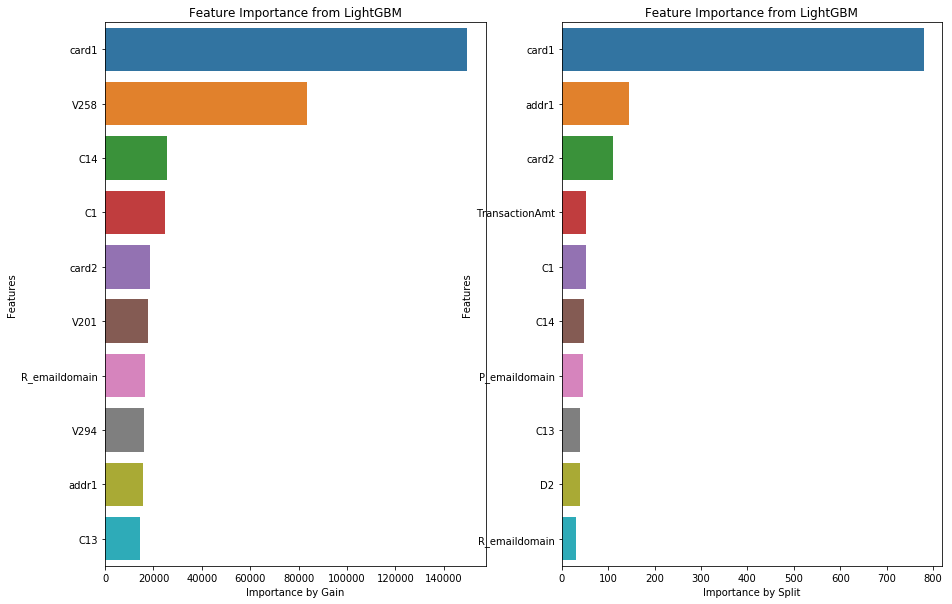

In [14]:
download_source()
Xt_test, Xt_train, Xi_test, Xi_train = get_data() 

cols_dropx = ['isFraud','TransactionDT','TransactionID']

X = Xt_train.drop(cols_dropx, axis=1)
pred_X = Xt_test.drop(['TransactionDT','TransactionID'], axis=1)

Y = Xt_train['isFraud']

categorical_cols = ['ProductCD','card1','card2','card3','card4', 'card5','card6','P_emaildomain','R_emaildomain', 'M1',
                                   'M2','M3','M4','M5','M6','M7','M8','M9','addr1','addr2']
categorical_cols_mod = ['ProductCD','card4','card6','P_emaildomain','R_emaildomain', 'M1',
                                   'M2','M3','M4','M5','M6','M7','M8','M9']

# Map the categorical columns for LightGBM
X,dict_train = prep_data(X, categorical_cols_mod)
# Split the label data to train and test 
X_train, X_test, y_train, y_test =  train_test_split(X, Y, test_size=0.20, random_state=42)

# Map the categorical columns in the submission file 

pred_X,dict_train = prep_data(pred_X, categorical_cols_mod,dict_train)

#Run light GBM 

gbm = lgbm(X_train, X_test, y_train, y_test)

#Plot top 10 feature importance 

imp_feature = plot_feature_importance(gbm,X_train,type='both',n_features=10)

Run the code below for Logistic regression 

In [19]:

X_train_log,X_test_log = X_train[(imp_feature)], X_test[(imp_feature)]
X_train_log,X_test_log = X_train_log.fillna(X_train_log.mean()),X_test_log.fillna(X_test_log.mean())
scaler = StandardScaler()
X_train_log = scaler.fit_transform(X_train_log)
X_test_log = scaler.transform(X_test_log)
model = train_logistic(X_train_log,y_train)
preds = model.predict_proba(X_test_log).T[1]
roc_auc_score(y_test.values, preds)


0.7138216419934222

In [0]:
def train_logistic(X_train, Y_train): 

  model = LogisticRegression(random_state=43, penalty='l2',solver='lbfgs').fit(X_train, Y_train) 
  return model

In [0]:
# Run Time series plots
plot_others(Xt_train, Xt_test)

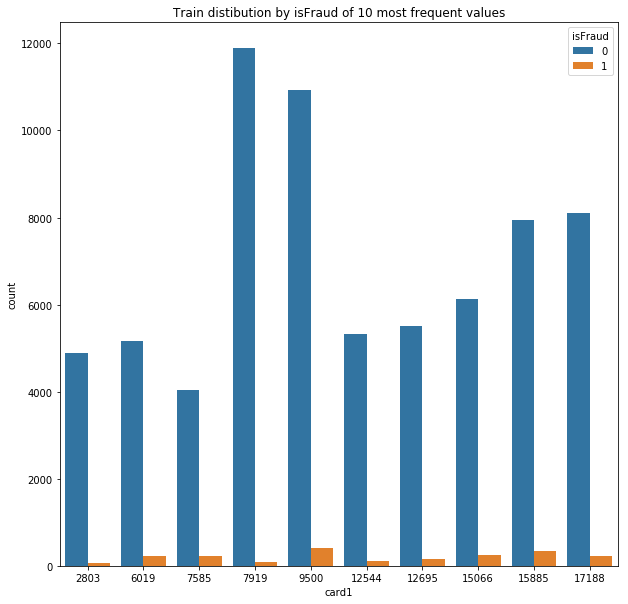

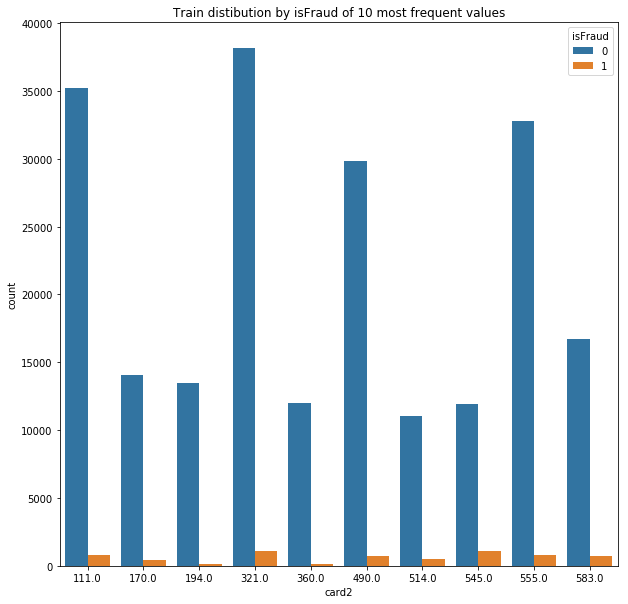

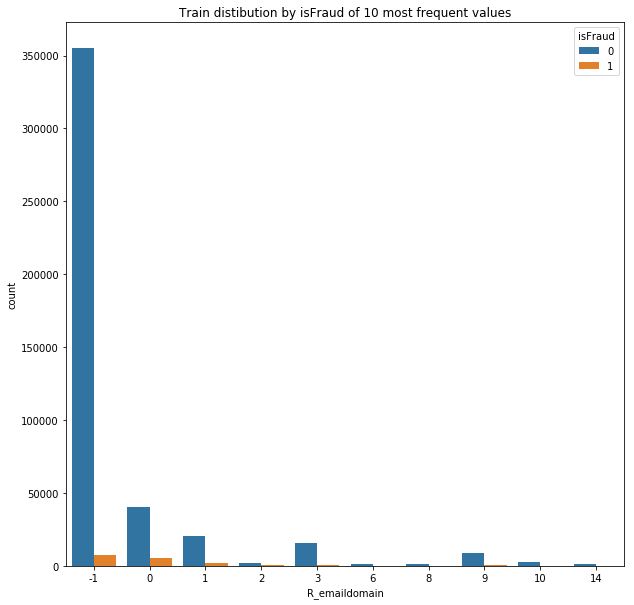

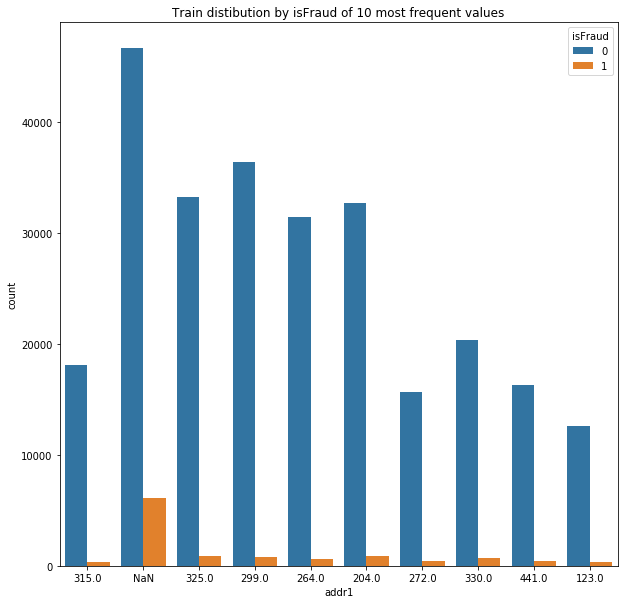

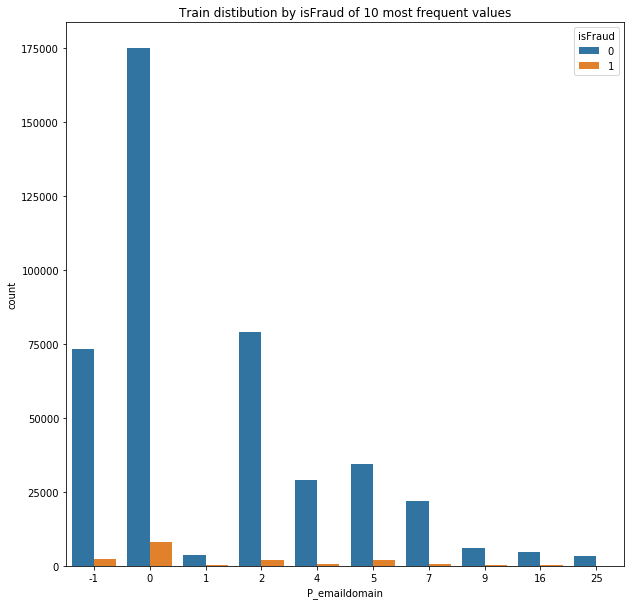

In [20]:
# Run Categorical plots 
for i in imp_feature: 
  if i in categorical_cols: 
    data = pd.concat([X_train[i],y_train],axis=1)
    plot_categorical(data,i,'isFraud',10)



In [0]:
## Run KDE plots 
for i in imp_feature: 
  if i not in categorical_cols: 
    data = pd.concat([X_train[i],y_train],axis=1)
    data = data.fillna(0)
    plot_numeric(data,i,'isFraud')


In [0]:
def prep_data(df,cols=[],dict={}): 
  if not dict: 
    for col in cols: 
      temp_dict = {} 
      lst = df[col].unique()
      j = 0 
      for i in lst:
        if  isinstance(i, float) and math.isnan(i) :
          temp_dict[i] = -1 
        else: 
          temp_dict[i] = j 
          j = j + 1 
      dict[col]=temp_dict 
  df.replace(dict, inplace=True)
  return df,dict

In [0]:
def plot_numeric(df,feature,target): 
    df[feature].fillna(0)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    sns.kdeplot(df[feature], ax=axes[0], label='Train');
    sns.kdeplot(df[df['isFraud']==0][feature], ax=axes[1], label='isFraud 0')
    sns.kdeplot(df[df['isFraud']==1][feature], ax=axes[1], label='isFraud 1')
    axes[0].set_title('Train KDE distribution for feature {}'.format(feature));
    axes[1].set_title('Target value KDE distribution for feature {}'.format(feature));
  
  
  

In [0]:
def plot_categorical(df,feature,target,values=5):
  
  df = df[df[feature].isin(df[feature].value_counts(dropna=False).head(values).index)]
  fig, axes = plt.subplots(1, 1, figsize=(10, 10))
  sns.countplot(x=feature, hue=target,data=df[[feature, target]].fillna('NaN'),ax=axes)
  axes.set_title('Train distibution by {} of {} most frequent values'.format(target, values));


In [0]:
def lgbm(X_train, X_test, y_train, y_test):

  lgb_train = lgb.Dataset(X_train, y_train)
  lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
  params = {
    #  'boosting_type': 'dart',
      'objective': 'binary',
      'metric': 'auc',
      'num_leaves': 20,
      'learning_rate': 0.06,
      'feature_fraction': 0.9,
      'bagging_fraction': 0.8,
      'bagging_freq': 5,
      'verbose': -1,
      'drop_rate' : .2,
      'class_weight':'balanced'
  }

  gbm = lgb.train(params,
                  lgb_train,
                  num_boost_round=100,
                  valid_sets=lgb_eval,
                  early_stopping_rounds=20,
                  categorical_feature=['ProductCD','card1','card2','card3','card4', 'card5','card6','P_emaildomain','R_emaildomain', 'M1',
                                     'M2','M3','M4','M5','M6','M7','M8','M9','addr1','addr2'])

  y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
  
  return gbm


In [0]:
def plot_feature_importance(gbm,data,type='both',n_features=10): 
  flst = []
  num_plots = 2 
  if(type == 'both'): 
    feature = gbm.feature_importance(importance_type='gain')
    feature1 = gbm.feature_importance(importance_type='split')
  elif type == 'gain': 
    feature = gbm.feature_importance(importance_type='gain')
    num_plots = 1
    feature_text = 'feature_gain'
  else:
    feature = gbm.feature_importance(importance_type='split')
    num_plots = 1
    feature_text = 'feature_split'

  f, ax = plt.subplots(1,num_plots,figsize=(15,10),sharex='none')

  if num_plots == 2: 
    dplot1=pd.DataFrame.from_dict({'col_name':data.columns.values,'feature_gain':feature})\
                        .sort_values('feature_gain',ascending=False)
    dplot2=pd.DataFrame.from_dict({'col_name':data.columns.values,'feature_split':feature1})\
                        .sort_values('feature_split',ascending=False) 
    dplot1 = dplot1.iloc[:n_features,:]
    dplot2 = dplot2.iloc[:n_features,:]

    sns.catplot(x="feature_gain", y="col_name", kind='bar', data = dplot1,ax=ax[0])
    sns.catplot(x="feature_split", y="col_name", kind='bar', data = dplot2,ax=ax[1])

    plt.close(2)
    plt.close(3)

    ax[0].set(xlabel='Importance by Gain', ylabel ='Features', title ='Feature Importance from LightGBM')
    ax[1].set(xlabel='Importance by Split', ylabel ='Features', title ='Feature Importance from LightGBM')
    
    flst = pd.concat([dplot1['col_name'],dplot2['col_name']]).unique()
  
  else: 
    
    dplot1=pd.DataFrame.from_dict({'col_name':data.columns.values,feature_text:feature})\
                        .sort_values(feature_text,ascending=False)
    
    dplot1 = dplot1.iloc[:n_features,:]

    sns.catplot(x=feature_text, y="col_name", kind='bar', data = dplot1,ax=ax)
    plt.close(2)
    
    if (feature_text == 'feature_gain'): 
          ax.set(xlabel='Importance by Gain', ylabel ='Features', title ='Feature Importance from LightGBM')
    else:
          ax.set(xlabel='Importance by Split', ylabel ='Features', title ='Feature Importance from LightGBM')

    flst = dplot1.col_name.unique()
   
  return flst 

In [0]:
def submit_kaggle():
  pred_X.loc[pred_X['P_emaildomain'] == 'scranton.edu','P_emaildomain'] = 59
  #print(pred_X['P_emaildomain'].unique())
  #pred_X['predict'] = kmeans.predict(pred_X.fillna(0)[(imp_feature)])
  y_pred = gbm.predict(pred_X[(imp_feature)], num_iteration=gbm.best_iteration)
  submit_df = pd.DataFrame.from_dict({'TransactionID':Xt_test['TransactionID'],'isFraud':y_pred})
  submit_df.to_csv('Submit01Sept18num8.csv',index=False)
  

In [0]:
# Try kmeans 
# from sklearn.cluster import MiniBatchKMeans
# X_train_km = X_train.fillna(0)
# X_train_km = X_train_km[(imp_feature)]
# kmeans = MiniBatchKMeans(n_clusters=5,random_state=0,batch_size=512)
# fit = kmeans.fit(X_train_km)
# print(y_train.shape,X_train.shape,X_train_km.shape)
# y_train_df = pd.DataFrame.from_dict({'isFraud': y_train,'predict': kmeans.predict(X_train_km)})
# print(y_train_df['predict'].value_counts())
# print(y_train_df.groupby(['predict'])[['isFraud']].sum())
# X_train['predict'] = kmeans.predict(X_train_km)
# X_test['predict'] = kmeans.predict(X_test.fillna(0)[(imp_feature)])



In [0]:
def plot_others(Xt_train, Xt_test): 
  # Frequency of Transacations by date 
  f, ax = plt.subplots(3,1,figsize=(10.5,20),sharex='none')

  df= Xt_train.set_index('TransactionDT')[['D6']].resample('D').count()
  df = df.reset_index()
  df['TransactionDT'] = mdates.date2num(df['TransactionDT'])

  g = sns.relplot(x="TransactionDT", y="D6", kind='line', data=df,ax=ax[0]);
  #ax[0].xaxis.set_major_locator(mdates.AutoDateLocator())
  ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m'))
  ax[0].set(xlabel='date', ylabel='transaction freq')
  ax[0].set(title = 'Test Frequency of Transactions')

  df1= Xt_train.set_index('TransactionDT')[['isFraud']].resample('D').mean()
  df1 = df1.reset_index()
  df1['TransactionDT'] = mdates.date2num(df1['TransactionDT'])
  sns.relplot(x="TransactionDT", y="isFraud", kind='line', data=df1,ax=ax[1]);
  ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m'))
  ax[1].set(xlabel='date', ylabel='average % fraud')
  ax[1].set(title = 'Average Fraudulent Transactions')


  df2= Xt_test.set_index('TransactionDT')[['D6']].resample('D').count()
  df2 = df2.reset_index()
  df2['TransactionDT'] = mdates.date2num(df2['TransactionDT'])
  g = sns.relplot(x="TransactionDT", y="D6", kind='line', color='g', data=df2,ax=ax[2]);
  ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m'))
  ax[2].set(xlabel='date', ylabel='transaction freq')
  ax[2].set(title = 'Train Frequency of Transactions')
  ax[2].set(ylim = (0,2000))



  ax[0].tick_params(axis='both', which='both', labelsize=12)
  ax[1].tick_params(axis='both', which='both', labelsize=12)
  ax[2].tick_params(axis='both', which='both', labelsize=12)

  # Delete empty figures

  plt.close(9)
  plt.close(8)
  plt.close(7)

